## 改編ContextUnet及相關代碼，使其首先對二維的情況適用。並於diffusers.Unet2DModel作比較並加以優化。最後再改寫爲3維的情形。
- 經試用diffusers的Unet2DModel，發現loss從0.3降到0.2但仍然很高，説明存在非Unet2DModel的問題可以優化
- 改用diffusers的DDMPScheduler和DDPMPipeline后，loss降低至0.1以下，有時甚至可以低至0.004，可見我的代碼問題主要出在DDPM部分。DDPMScheduler部分比較簡短，似乎沒有問題，所以問題應該在DDPMPipeline裏某一部分代碼是我代碼欠缺的。
- 我在DDPMScheduler部分有一個typo，導致beta_t一直很小，修正后loss從0.2能降低至0.02, 維持在0.1以下
- 用diffusers的DDPMScheduler似乎效果要好一些，loss總是比我的DDPMScheduler要小一點。儅epoch為19時，前者的loss約0.02，後者loss約0.07。而且前者還支持3維圖像的加噪，不如直接用別人的輪子。但我想知道爲什麽我的loss會高一些。
- 我意識到別人的DDPMScheduler在sample函數中沒有兼容輸入參數，所以歸根結底還是需要我的DDPMscheduler。不過我可以先用別人的來debug我的ContextUnet.
- 我需要將我的ContextUnet擴展兼容不同維度的照片，畢竟我本身也需要和原文獻對比完了再拓展到三維的情形
- 我已將我的ContextUnet轉成了2維的模式，與diffusers.Unet2DModel的loss=0.037相比，我的Unet的loss=0.07。同時我的Unet生成的圖像看上去很奇怪，説明我的Unet也有問題。我需要將代碼退回原Unet，並檢查問題所在。
- 我將紅移方向的像素的數量限制在了64.以此比較兩個Unet的差別。經比較：\
Unet2DModel loss：0.03, 0.0655, 0.05, 0.02, 0.05\
ContextUnet loss: 0.1, 0.16, 0.1, 0.2186, 0.06
- 我把ContextUnet退回到了原作者的版本，結果loss=0.05，輸出的照片也不錯。我主要的改動是改回了他原用的normalization函數，其中還有個參數swish。有時間我可以研究一下具體是哪裏影響了訓練的結果。另外我發現了要想tensorboard的圖綫獨立美觀，需要把他們放在不同的文件夾下
- 經過驗證，GroupNorm比batchNorm效果要好
- 已擴展爲接受不同維度的情形
- 融合cond, guide_w, drop_out這些參數
- 生成的21cm圖像該暗的地方不夠暗，似乎換成MNIST的數字圖像就沒問題
- 我用diffusion模型生成MNIST的數字時發現，儘管生成的數據的範圍也存在負數數值，如-0.1,但畫出來的圖像卻是理想的黑色。數據的分佈與21cm的結果的分佈沒多大差別，我現在打算把代碼退回到21cm的情形

In [1]:
from huggingface_hub import notebook_login
notebook_login()

In [2]:
from dataclasses import dataclass
import h5py
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
# from datasets import Dataset
import matplotlib.pyplot as plt
import numpy as np
import random
from abc import ABC, abstractmethod
import torch.nn.functional as F
import math
from PIL import Image
import os
from torch.utils.tensorboard import SummaryWriter
import copy
from tqdm.auto import tqdm
# from torchvision import transforms
# from diffusers import UNet2DModel#, UNet3DConditionModel
# from diffusers import DDPMScheduler
from diffusers.utils import make_image_grid
import datetime
from pathlib import Path
from diffusers.optimization import get_cosine_schedule_with_warmup
from accelerate import notebook_launcher, Accelerator
from huggingface_hub import create_repo, upload_folder

In [3]:
# params = torch.randn(10,2).numpy()
# drop_prob = 0.2
# cond_filter = torch.bernoulli(torch.ones(params.shape[0],1)-drop_prob).repeat(1,params.shape[1]).numpy()
# print(params.shape)
# print(cond_filter.shape)
# print(cond_filter)
# print(cond_filter[:,0].sum())
# cond_filter * params

In [4]:
# @dataclass
# class TrainConfig:
#     ###########################
#     ## hardcoding these here ##
#     ###########################
#     push_to_hub = "Xsmos/ml21cm"
#     hub_private_repo = False
#     dataset_name = "/storage/home/hcoda1/3/bxia34/scratch/LEN128-DIM64-CUB8.h5"
#     device = 'cuda' if torch.cuda.is_available() else 'cpu'

#     num_image = 600
#     HII_DIM = 64
#     num_redshift = 64#512#128
#     n_epoch = 35#2#5#25 # 120
#     num_timesteps = 1000#1000 # 1000, 500; DDPM time steps
#     train_batch_size = 20#10#20#2#100 # 10
#     n_sample = 25 # 64, the number of samples in sampling process
#     n_param = 2
#     guide_w = 0#-1#0#-1#0.1#[0,0.1] #[0,0.5,2] strength of generative guidance
#     drop_prob = 0.28 # only takes effect when guide_w != -1
#     ema=True # whether to use ema
#     ema_rate=0.995
    
#     seed = 0
#     save_dir = './outputs/'

#     sample_freq = 0#.1 # the period of sampling
#     stride = (2,2)
#     img_dim = len(stride)
#     # general parameters for the name and logger    
#     device = "cuda" if torch.cuda.is_available() else "cpu"
#     lrate = 1e-4
#     save_model = False
#     save_freq = 1 #10 # the period of saving model
#     # cond = True # if training using the conditional information
#     lr_decay = True#False # if using the learning rate decay
#     resume = False # if resume from the trained checkpoints
#     test_param_single=torch.tensor([0.2,0.80000023])
#     test_param = torch.tile(test_param_single,(n_sample,1)).to(device)
#     test_param =  test_param
#     data_dir = './data' # data directory

#     date = datetime.datetime.now().strftime("%m%d-%H%M")
#     run_name = f'{date}_guide_w{guide_w}' # the unique name of each experiment

# # config = TrainConfig()
# # print("device =", config.device)

In [5]:
# !h5dump -H /storage/home/hcoda1/3/bxia34/scratch/LEN512-DIM256.h5

In [6]:
class Dataset4h5(Dataset):
    def __init__(self, dir_name, num_image=10, field='brightness_temp', shuffle=True, idx=None, num_redshift=32, HII_DIM=32, rescale=True, drop_prob = 0):
        super().__init__()
        
        self.dir_name = dir_name
        self.num_image = num_image
        self.field = field
        self.shuffle = shuffle
        self.idx = idx
        self.num_redshift = num_redshift
        self.HII_DIM = HII_DIM
        self.drop_prob = drop_prob

        self.load_h5()
        if rescale:
            self.images = self.rescale(self.images, to=[-1,1])
            self.params = self.rescale(self.params, to=[0,1])

        self.len = len(self.params)
        self.images = torch.from_numpy(self.images)
        print(f"images rescaled to [{self.images.min()}, {self.images.max()}]")

        cond_filter = torch.bernoulli(torch.ones(self.params.shape[0],1)-self.drop_prob).repeat(1,self.params.shape[1]).numpy()
        self.params = torch.from_numpy(self.params*cond_filter)
        print(f"params rescaled to [{self.params.min()}, {self.params.max()}]")

    def load_h5(self):
        with h5py.File(self.dir_name, 'r') as f:
            print(f"dataset content: {f.keys()}")
            max_num_image = f['brightness_temp'].shape[0]
            print(f"{max_num_image} images can be loaded")
            field_shape = f['brightness_temp'].shape[1:]
            print(f"field.shape = {field_shape}")
            self.params_keys = list(f['params']['keys'])
            print(f"params keys = {self.params_keys}")

            if self.idx is None:
                if self.shuffle:
                    self.idx = np.sort(random.sample(range(max_num_image), self.num_image))
                    print(f"loading {self.num_image} images randomly")
                    # print(self.idx)
                else:
                    self.idx = range(self.num_image)
                    print(f"loading {len(self.idx)} images with idx = {self.idx}")
            else:
                print(f"loading {len(self.idx)} images with idx = {self.idx}")

            self.images = f[self.field][self.idx,0,:self.HII_DIM,-self.num_redshift:][:,None]
            print(f"images loaded:", self.images.shape)

            self.params = f['params']['values'][self.idx]
            print("params loaded:", self.params.shape)
            
            # plt.imshow(self.images[0,0,0])
            # plt.show()

    def rescale(self, value, to: list):
        # print(np.ndim(value))
        if np.ndim(value)==2:
            # print(f"rescale params of shape {value.shape}")
            ranges = \
                {
                    0: [4, 6], # ION_Tvir_MIN
                    1: [10, 250], # HII_EFF_FACTOR
                }
        # elif np.ndim(value)==5:  
        else:  
            # value = np.array(value)
            # print(f"rescale images of shape {np.shape(value)}")
            ranges = \
                {
                    0: [0, 80], # brightness_temp
                }
        # print(f"value.min = {value.min()}, value.max = {value.max()}")
        for i in range(np.shape(value)[1]):
            value[:,i] = (value[:,i] - ranges[i][0]) / (ranges[i][1]-ranges[i][0])
        # print(f"value.min = {value.min()}, value.max = {value.max()}")
        value = value * (to[1]-to[0]) + to[0]
        return value 

    def __getitem__(self, index):
        return self.images[index], self.params[index]

    def __len__(self):
        return self.len

In [7]:
# dataset = Dataset4h5(config.dataset_name)
# dataloader = DataLoader(dataset, batch_size=100, shuffle=True)

In [8]:
# from torchvision.datasets import MNIST
# from torchvision import transforms
# tf = transforms.Compose([transforms.ToTensor()]) # mnist is already normalised 0 to 1
# dataset = MNIST("./data", train=True, download=True, transform=tf)
# dataloader = DataLoader(dataset, batch_size=100, shuffle=True, num_workers=5)

In [9]:
# images, params = next(iter(dataloader))
# print(images.shape)
# print(images.max(), images.min())
# print(params.shape)
# print(params.max(), params.min())
# # plt.imshow(images[0,0])

In [10]:
# # def plot(filename, row=10, col=10):
# # samples = np.load(filename)
# # params = filename.split('guide_w')[-1][:-4]
# # print("plotting", samples.shape, params)
# plt.figure(figsize = (10,10))
# for i in range(100):
#     plt.subplot(10,10,i+1)
#     plt.imshow(images[i,0,:,:], cmap='gray')#, vmin=-1, vmax=1)
#     plt.xticks([])
#     plt.yticks([])
#     # plt.show()
# # plt.suptitle(params)
# plt.tight_layout()
# plt.subplots_adjust(wspace=0, hspace=0)
# plt.show()
# # plt.savefig('outputs/'+params+'.png')
# # plt.close()
# # plt.imshow(images[0,0])
# # plt.show()

In [11]:
# image = images[0,0]
# print(image.shape)
# plt.imshow(image)
# plt.show()
# _ = plt.hist(image.flatten(), bins=50)

In [12]:
# with h5py.File(config.dataset_name, 'r') as f:
#     print(f.keys())
#     print(f['params']['values'])
#     params_np = np.array(f['params']['values'][:3600])
#     print(params_np.shape)

In [13]:
# plt.scatter(params_np[:,0], params_np[:,1], s=1)

In [14]:
# dataset = Dataset4h5(config.dataset_name, num_image=7200)
# dataloader = DataLoader(dataset, batch_size=100, shuffle=True)
# images, params = next(iter(dataloader))
# print(images.shape)
# print(images.max(), images.min())
# print(params.shape)
# print(params.max(), params.min())
# # plt.imshow(images[0,0])

In [15]:
# plt.figure(figsize = (10,10))
# eps = 0.069
# param = config.test_param_single.numpy()
# j = 1
# for (x, c) in dataloader:
#     # print('x.shape', x.shape)
#     # print('len(dataloader) =', len(dataloader))
#     label = (c[:,0] >= param[0] - eps) * \
#         (c[:,0] <= param[0] + eps) * \
#             (c[:,1] >= param[1] - eps) * \
#                 (c[:,1] <= param[1] + eps)
#     # print(label)
#     # print(torch.sum(label), label.shape)
    
#     for i in range(x.shape[0]):
#         if (param[0]-eps<=c[i][0]<=param[0]+eps) and (param[1]-eps<=c[i][1]<=param[1]+eps):
#             print(c[i])
#             plt.subplot(10,10,j)
#             plt.imshow(images[i,0,:,:])
#             plt.xticks([])
#             plt.yticks([])
#             j += 1
            
#             # print("j =", j)
#             if j == 101:
#                 break

#     if j == 101:
#         break
#         # plt.show()
#     # plt.suptitle(params)
# plt.tight_layout()
# plt.subplots_adjust(wspace=0, hspace=0)
# plt.show()

# Add noise:

\begin{align*}
x_t &\sim \mathcal N\left(\sqrt{1-\beta_t}\ x_{t-1},\ \beta_t \right) \\
x_t &\equiv \sqrt{1-\beta_t}\ x_{t-1} + \sqrt{\beta_t}\ \epsilon\\
\epsilon &\sim \mathcal N(0,1)\\
\alpha_t & \equiv 1 - \beta_t\\
& ...\\
x_t &= \sqrt{\bar {\alpha_t}} x_0 + \epsilon\ \sqrt{1 - \bar{\alpha_t}}\\
\bar {\alpha_t} &\equiv \prod_{i=1}^t \alpha_i\\
&= \exp\left({\ln{\prod_{i=1}^t \alpha_i}}\right)\\
&= \exp\left({\sum_{i=1}^t\ln{ \alpha_i}}\right)
\end{align*}

In [16]:
class DDPMScheduler(nn.Module):
    def __init__(self, betas: tuple, num_timesteps: int, device='cpu'):
        super().__init__()
        
        beta_1, beta_T = betas
        assert 0 < beta_1 <= beta_T <= 1, "ensure 0 < beta_1 <= beta_T <= 1"
        self.device = device
        self.num_timesteps = num_timesteps
        self.beta_t = torch.linspace(beta_1, beta_T, self.num_timesteps) #* (beta_T-beta_1) + beta_1
        self.beta_t = self.beta_t.to(self.device)

        # self.drop_prob = drop_prob
        # self.cond = cond
        self.alpha_t = 1 - self.beta_t
        # self.bar_alpha_t = torch.exp(torch.cumsum(torch.log(self.alpha_t), dim=0))
        self.bar_alpha_t = torch.cumprod(self.alpha_t, dim=0)

    def add_noise(self, clean_images):
        shape = clean_images.shape
        expand = torch.ones(len(shape)-1, dtype=int)
        # ts_expand = ts.view(ts.shape[0], *expand.tolist())
        # expand = [1 for i in range(len(shape)-1)]

        noise = torch.randn_like(clean_images).to(self.device)
        ts = torch.randint(0, self.num_timesteps, (shape[0],)).to(self.device)
                
        # test_expand = test.view(test.shape[0],*expand)
        # extend_dim = [None for i in range(shape.dim()-1)]
        noisy_images = (
            clean_images * torch.sqrt(self.bar_alpha_t[ts]).view(shape[0], *expand.tolist())
            + noise * torch.sqrt(1-self.bar_alpha_t[ts]).view(shape[0], *expand.tolist())
            )
        # print(x_t.shape)

        return noisy_images, noise, ts

    def sample(self, nn_model, n_sample, shape, device, test_param, guide_w = -1):
        x_i = torch.randn(n_sample, *shape).to(device)
        # print("x_i.shape =", x_i.shape)
        if guide_w != -1:
            c_i = test_param
            uncond_tokens = torch.zeros(int(n_sample), test_param.shape[1]).to(device)
            # uncond_tokens = torch.tensor(np.float32(np.array([0,0]))).to(device)
            # uncond_tokens = uncond_tokens.repeat(int(n_sample),1)
            c_i = torch.cat((c_i, uncond_tokens), 0)

        x_i_entire = [] # keep track of generated steps in case want to plot something
        # print("self.num_timesteps =", self.num_timesteps)
        # for i in range(self.num_timesteps, 0, -1):
        # print(f'sampling!!!')
        pbar_sample = tqdm(total=self.num_timesteps)
        pbar_sample.set_description("Sampling")
        for i in reversed(range(0, self.num_timesteps)):
            # print(f'sampling timestep {i:4d}',end='\r')
            t_is = torch.tensor([i]).to(device)
            t_is = t_is.repeat(n_sample)

            z = torch.randn(n_sample, *shape).to(device) if i > 0 else 0

            if guide_w == -1:
                # eps = nn_model(x_i, t_is, return_dict=False)[0]
                eps = nn_model(x_i, t_is)
                # x_i = 1/torch.sqrt(self.alpha_t[i])*(x_i-eps*self.beta_t[i]/torch.sqrt(1-self.bar_alpha_t[i])) + torch.sqrt(self.beta_t[i])*z
            else:
                # double batch
                x_i = x_i.repeat(2, *torch.ones(len(shape), dtype=int).tolist())
                t_is = t_is.repeat(2)

                # split predictions and compute weighting
                eps = nn_model(x_i, t_is, c_i)
                eps1 = eps[:n_sample]
                eps2 = eps[n_sample:]
                eps = eps1 + guide_w*(eps1 - eps2)
                # eps = (1+guide_w)*eps1 - guide_w*eps2
                x_i = x_i[:n_sample]
                # x_i = 1/torch.sqrt(self.alpha_t[i])*(x_i-eps*self.beta_t[i]/torch.sqrt(1-self.bar_alpha_t[i])) + torch.sqrt(self.beta_t[i])*z
            
            # print("x_i.shape =", x_i.shape)
            x_i = 1/torch.sqrt(self.alpha_t[i])*(x_i-eps*self.beta_t[i]/torch.sqrt(1-self.bar_alpha_t[i])) + torch.sqrt(self.beta_t[i])*z
            
            pbar_sample.update(1)
            # pbar_sample.set_postfix(step=i)
            
            # print("x_i.shape =", x_i.shape)
            # store only part of the intermediate steps
            if i%20==0:# or i==0:# or i<8:
                x_i_entire.append(x_i.detach().cpu().numpy())
        x_i = x_i.detach().cpu().numpy()
        x_i_entire = np.array(x_i_entire)
        return x_i, x_i_entire


# ddpm_scheduler = DDPMScheduler((1e-4,0.02),10)
# noisy_images, noise, ts = ddpm_scheduler.add_noise(images)

In [17]:
class GroupNorm32(nn.GroupNorm):
    def __init__(self, num_groups, num_channels, swish, eps=1e-5):
        super().__init__(num_groups=num_groups, num_channels=num_channels, eps=eps)
        self.swish = swish

    def forward(self, x):
        y = super().forward(x.float()).to(x.dtype)
        if self.swish == 1.0:
            y = F.silu(y)
        elif self.swish:
            y = y * F.sigmoid(y * float(self.swish))
        return y

def normalization(channels, swish=0.0):
    """
    Make a standard normalization layer, with an optional swish activation.

    :param channels: number of input channels.
    :return: an nn.Module for normalization.
    """
    #print (channels)
    return GroupNorm32(num_channels=channels, num_groups=32, swish=swish)

Conv = {
    1: nn.Conv1d,
    2: nn.Conv2d,
    3: nn.Conv3d,
}

AvgPool = {
    1: nn.AvgPool1d,
    2: nn.AvgPool2d,
    3: nn.AvgPool3d
}

In [18]:
class Downsample(nn.Module):
    def __init__(self, channels, use_conv, out_channels=None):
        super().__init__()
        self.channels = channels
        self.out_channels = out_channels or channels
        stride = config.stride
        if use_conv:
            # print("conv")
            self.op = Conv[config.img_dim](channels, self.out_channels, 3, stride=stride, padding=1)
        else:
            # print("pool")
            assert channels == self.out_channels
            self.op = AvgPool[config.img_dim](kernel_size=stride, stride=stride)

    def forward(self, x):
        assert x.shape[1] == self.channels
        return self.op(x)

In [19]:
class Upsample(nn.Module):
    def __init__(self, channels, use_conv, out_channels=None):
        super().__init__()
        self.channels = channels
        self.out_channels = out_channels
        self.use_conv = use_conv
        if self.use_conv:
            self.conv = Conv[config.img_dim](self.channels, self.out_channels, 3, padding=1)

    def forward(self, x):
        assert x.shape[1] == self.channels
        stride = config.stride
        # print(torch.tensor(x.shape[2:]))
        # print(torch.tensor(stride))
        shape = torch.tensor(x.shape[2:]) * torch.tensor(stride)
        shape = tuple(shape.detach().numpy())
        # print(shape)
        x = F.interpolate(x, shape, mode='nearest')
        if self.use_conv:
            x = self.conv(x)
        return x

In [20]:
def zero_module(module):
    """
    clean gradient of parameters of the module
    """
    for p in module.parameters():
        p.detach().zero_()
    return module

In [21]:
class TimestepBlock(ABC, nn.Module):
    @abstractmethod
    def forward(self, x, emb):
        """
        test
        """

In [22]:
class TimestepEmbedSequential(nn.Sequential, TimestepBlock):
    def forward(self, x, emb, encoder_out=None):
        for layer in self:
            if isinstance(layer, TimestepBlock):
                x = layer(x, emb)
            elif isinstance(layer, AttentionBlock):
                x = layer(x, encoder_out)
            else:
                x = layer(x)
        return x

In [23]:
class ResBlock(TimestepBlock):
    def __init__(
        self, channels, emb_channels, dropout, out_channels=None, use_conv=False, use_checkpoint=False, use_scale_shift_norm=False, up=False, down=False,
        ):
        super().__init__()
        self.out_channels = out_channels or channels
        self.use_scale_shift_norm = use_scale_shift_norm

        self.in_layers = nn.Sequential(
            # nn.BatchNorm2d(channels), # normalize to standard gaussian
            normalization(channels, swish=1.0),
            nn.Identity(),
            Conv[config.img_dim](channels, self.out_channels, 3, padding=1),
            )

        self.updown = up or down
        if up:
            self.h_updown = Upsample(channels, False)
            self.x_updown = Upsample(channels, False)
        elif down:
            self.h_updown = Downsample(channels, False)
            self.x_updown = Downsample(channels, False)
        else:
            self.h_updown = self.x_updown = nn.Identity()

        self.emb_layers = nn.Sequential(
            nn.SiLU(),
            nn.Linear(
                emb_channels,
                2 * self.out_channels if use_scale_shift_norm else self.out_channels,
                ),
        )

        self.out_layers = nn.Sequential(
            # nn.BatchNorm2d(self.out_channels),
            normalization(self.out_channels, swish=0.0 if use_scale_shift_norm else 1.0),
            nn.SiLU() if use_scale_shift_norm else nn.Identity(),
            nn.Dropout(p=dropout),
            zero_module(Conv[config.img_dim](self.out_channels, self.out_channels, 3, padding=1)),
        )

        if self.out_channels == channels:
            self.skip_connection = nn.Identity()
        elif use_conv:
            self.skip_connection = Conv[config.img_dim](channels, self.out_channels, 3, padding=1)
        else:
            self.skip_connection = Conv[config.img_dim](channels, self.out_channels, 1)
        

    def forward(self, x, emb):
        if self.updown:
            in_rest, in_conv = self.in_layers[:-1], self.in_layers[-1]
            h = in_rest(x)
            h = self.h_updown(h)
            x = self.x_updown(x)
            h = in_conv(h)
        else:
            h = self.in_layers(x)
        emb_out = self.emb_layers(emb).type(h.dtype)

        while len(emb_out.shape) < len(h.shape):
            emb_out = emb_out[..., None]

        if self.use_scale_shift_norm:
            out_norm, out_rest = self.out_layers[0], self.out_layers[1:]
            scale, shift = torch.chunk(emb_out, 2, dim=1)
            h = out_norm(h) * (1+scale) + shift
            h = out_rest(h)
        else:
            h += emb_out
            h = self.out_layers(h)
        # print("ResBlock, torch.unique(h).shape =", torch.unique(h).shape)
        return self.skip_connection(x) + h

In [24]:
class QKVAttention(nn.Module):
    def __init__(self, n_heads):
        super().__init__()
        self.n_heads = n_heads
        # print("QKVAttention, self.n_heads =", self.n_heads)
        
    def forward(self, qkv, encoder_kv=None):
        bs, width, length = qkv.shape
        assert width % (3*self.n_heads) == 0
        ch = width // (3*self.n_heads)

        # print("QKVAttention", bs, self.n_heads, ch, length)
        q, k, v = qkv.reshape(bs*self.n_heads, ch*3, length).split(ch, dim=1)
        if encoder_kv is not None:
            assert encoder_kv.shape[1] == self.n_heads * ch * 2
            ek, ev = encoder_kv.reshape(bs*self.n_heads, ch*2, -1).split(ch, dim=1)
            k = torch.cat([ek,k], dim=-1)
            v = torch.cat([ev,v], dim=-1)

        scale = 1 / math.sqrt(math.sqrt(ch))
        weight = torch.einsum("bct,bcs->bts", q*scale, k*scale)
        weight = torch.softmax(weight.float(), dim=-1).type(weight.dtype)

        a = torch.einsum("bts,bcs->bct", weight, v)
        return a.reshape(bs, -1, length)

In [25]:
class AttentionBlock(nn.Module):
    def __init__(
        self,
        channels,
        num_heads=1,
        num_head_channels=-1,
        use_checkpoint=False,
        encoder_channels=None,
    ):
        super().__init__()
        self.channels = channels
        if num_head_channels == -1:
            self.num_heads = num_heads
        else:
            assert channels % num_head_channels == 0,\
                f"q,k,v channels {channels} is not divisible by num_head_channels {num_head_channels}"
            self.num_heads = channels // num_head_channels

        self.use_checkpoint = use_checkpoint
        # self.norm = nn.BatchNorm2d(channels)
        self.norm = normalization(channels, swish=0.0)
        self.qkv = nn.Conv1d(channels, channels * 3, 1)
        
        self.attention = QKVAttention(self.num_heads)

        if encoder_channels is not None:
            self.encoder_kv = nn.Conv1d(encoder_channels, channels * 2, 1)
        self.proj_out = zero_module(nn.Conv1d(channels, channels, 1))

    def forward(self, x, encoder_out=None):
        b, c, *spatial = x.shape
        qkv = self.qkv(self.norm(x).view(b, c, -1))
        if encoder_out is not None:
            encoder_out = self.encoder_kv(encoder_out)
            h = self.attention(qkv, encoder_out)
        else:
            h = self.attention(qkv)
        # print("AttentionBlock, before proj_out, torch.unique(h).shape =", torch.unique(h).shape)
        h = self.proj_out(h)
        # print("AttentionBlock, after proj_out, torch.unique(h).shape =", torch.unique(h).shape)
        return x + h.reshape(b, c, *spatial)

In [26]:
def timestep_embedding(timesteps, dim, max_period=10000):
    """
    Create sinusoidal timestep embeddings.

    :param timesteps: a 1-D Tensor of N indices, one per batch element.
                      These may be fractional.
    :param dim: the dimension of the output.
    :param max_period: controls the minimum frequency of the embeddings.
    :return: an [N x dim] Tensor of positional embeddings.
    """
    #print (timesteps.shape)
    half = dim // 2
    freqs = torch.exp(
        -math.log(max_period) * torch.arange(start=0, end=half, dtype=torch.float32) / half
    ).to(device=timesteps.device)
    #print (timesteps[:, None].float().shape,freqs[None].shape)
    args = timesteps[:, None].float() * freqs[None]
    embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
    if dim % 2:
        embedding = torch.cat([embedding, torch.zeros_like(embedding[:, :1])], dim=-1)
    return embedding

In [27]:
class ContextUnet(nn.Module):
    def __init__(
        self,
        n_param=2,
        image_size=64,
        in_channels=1,
        model_channels=128,
        out_channels = 1,
        channel_mult = None,
        num_res_blocks = 2,
        dropout = 0,
        use_checkpoint = False,
        use_scale_shift_norm = False,
        attention_resolutions = (16, 8),
        num_heads = 4,
        num_head_channels = -1,
        num_heads_upsample = -1,
        resblock_updown = False,
        conv_resample = True,
        encoder_channels = None,
        ):
        super().__init__()

        if channel_mult == None:
            if image_size == 512:
                channel_mult = (0.5, 1, 1, 2, 2, 4, 4)
            elif image_size == 256:
                channel_mult = (1, 1, 2, 2, 4, 4)
            elif image_size == 128:
                channel_mult = (1, 1, 2, 3, 4)
            elif image_size == 64:
                channel_mult = (1, 1, 2, 2, 4, 4)#(1, 2, 3, 4)
            elif image_size == 28:
                channel_mult = (1, 2)#(1, 2, 3, 4)
            else:
                raise ValueError(f"unsupported image size: {image_size}")
        # else:
        #     channel_mult = tuple(int(ch_mult) for ch_mult in channel_mult.split(","))
        
        attention_ds = []
        for res in attention_resolutions:
            attention_ds.append(image_size // int(res))

        # print("before, ContextUnet, num_heads_upsample =", num_heads_upsample, "num_heads =", num_heads)
        if num_heads_upsample == -1:
            num_heads_upsample = num_heads
        # print("after, ContextUnet, num_heads_upsample =", num_heads_upsample, "num_heads =", num_heads)

        # self.n_param = n_param
        self.model_channels = model_channels
        self.dtype = torch.float32

        self.token_embedding = nn.Linear(n_param, model_channels * 4)

        time_embed_dim = model_channels * 4
        self.time_embed = nn.Sequential(
            nn.Linear(model_channels, time_embed_dim),
            nn.SiLU(),
            nn.Linear(time_embed_dim, time_embed_dim),
        )

        ch = input_ch = int(channel_mult[0] * model_channels)

        ###################### input_blocks ######################
        self.input_blocks = nn.ModuleList(
            [TimestepEmbedSequential(Conv[config.img_dim](in_channels, ch, 3, padding=1))]
        )
        self._feature_size = ch
        input_block_chans = [ch]
        ds = 1

        for level, mult in enumerate(channel_mult):
            for _ in range(num_res_blocks):
                layers = [
                    ResBlock(
                        ch,
                        time_embed_dim,
                        dropout,
                        out_channels = int(mult * model_channels),
                        use_checkpoint = use_checkpoint,
                        use_scale_shift_norm = use_scale_shift_norm,
                    )
                ]
                ch = int(mult * model_channels)
                if ds in attention_ds:
                    layers.append(
                        AttentionBlock(
                            ch,
                            use_checkpoint=use_checkpoint,
                            num_heads = num_heads,
                            num_head_channels = num_head_channels,
                            encoder_channels = encoder_channels,
                        )
                    )
                self.input_blocks.append(TimestepEmbedSequential(*layers))
                self._feature_size += ch
                input_block_chans.append(ch)

            if level != len(channel_mult) - 1:
                out_ch = ch
                self.input_blocks.append(
                    TimestepEmbedSequential(
                        ResBlock(
                            ch,
                            time_embed_dim,
                            dropout,
                            out_channels=out_ch,
                            # dims=dims,
                            use_checkpoint=use_checkpoint,
                            use_scale_shift_norm=use_scale_shift_norm,
                            down=True,
                        )
                        if resblock_updown
                        else Downsample(ch, conv_resample, out_channels=out_ch)
                    )
                )
                ch = out_ch
                input_block_chans.append(ch)
                ds *= 2
                self._feature_size += ch


        ###################### middle_blocks ######################
        self.middle_block = TimestepEmbedSequential(
            ResBlock(
                ch,
                time_embed_dim,
                dropout,
                use_checkpoint=use_checkpoint,
                use_scale_shift_norm=use_scale_shift_norm,
            ),
            AttentionBlock(
                ch,
                use_checkpoint=use_checkpoint,
                num_heads=num_heads,
                num_head_channels=num_head_channels,
                encoder_channels=encoder_channels,
            ),
            ResBlock(
                ch,
                time_embed_dim,
                dropout,
                use_checkpoint=use_checkpoint,
                use_scale_shift_norm=use_scale_shift_norm,
            ),
        )
        self._feature_size += ch


        ###################### output_blocks ######################
        self.output_blocks = nn.ModuleList([])
        for level, mult in list(enumerate(channel_mult))[::-1]:
            for i in range(num_res_blocks + 1):
                ich = input_block_chans.pop()
                layers = [
                    ResBlock(
                        ch + ich,
                        time_embed_dim,
                        dropout,
                        out_channels=int(model_channels * mult),
                        # dims=dims,
                        use_checkpoint=use_checkpoint,
                        use_scale_shift_norm=use_scale_shift_norm,
                    )
                ]
                ch = int(model_channels * mult)
                if ds in attention_ds:
                    # print("ds in attention_resolutions, num_heads=", num_heads_upsample)
                    layers.append(
                        AttentionBlock(
                            ch,
                            use_checkpoint=use_checkpoint,
                            num_heads=num_heads_upsample,
                            num_head_channels=num_head_channels,
                            encoder_channels=encoder_channels,
                        )
                    )
                if level and i == num_res_blocks:
                    out_ch = ch
                    layers.append(
                        ResBlock(
                            ch,
                            time_embed_dim,
                            dropout,
                            out_channels=out_ch,
                            # dims=dims,
                            use_checkpoint=use_checkpoint,
                            use_scale_shift_norm=use_scale_shift_norm,
                            up=True,
                        )
                        if resblock_updown
                        else Upsample(ch, conv_resample, out_channels=out_ch)
                    )
                    ds //= 2
                self.output_blocks.append(TimestepEmbedSequential(*layers))
                self._feature_size += ch

        self.out = nn.Sequential(
            # nn.BatchNorm2d(ch),
            normalization(ch, swish=1.0),
            nn.Identity(),
            zero_module(Conv[config.img_dim](input_ch, out_channels, 3, padding=1)),
        )
        # self.use_fp16 = use_fp16

    def forward(self, x, timesteps, y=None):
        hs = []
        emb = self.time_embed(timestep_embedding(timesteps, self.model_channels))
        if y != None:
            text_outputs = self.token_embedding(y.float())
            emb = emb + text_outputs.to(emb)

        h = x.type(self.dtype)
        # print("0,h.shape =", h.shape)
        for module in self.input_blocks:
            h = module(h, emb)
            hs.append(h)
            # print("module encoder, h.shape =", h.shape)
        # print("2,h.shape =", h.shape)
        h = self.middle_block(h, emb)
        # print("middle block, h.shape =", h.shape)
        # print("2,h.shape =", h.shape)
        for module in self.output_blocks:
            # print("for module in self.output_blocks, h.shape =", h.shape)
            # print("len(hs) =", len(hs), ", hs[-1].shape =", hs[-1].shape)
            h = torch.cat([h, hs.pop()], dim=1)
            h = module(h, emb)
            # print("module decoder, h.shape =", h.shape)

        h = h.type(x.dtype)
        h = self.out(h)
        # print("self.out(h)", "h.shape =", h.shape)

        return h 

In [28]:
class EMA:
    def __init__(self, beta):
        super().__init__()
        self.beta = beta
        self.step = 0

    def update_model_average(self, ma_model, current_model):
        for current_params, ma_params in zip(current_model.parameters(), ma_model.parameters()):
            old_weight, up_weight = ma_params.data, current_params.data
            ma_params.data = self.update_average(old_weight, up_weight)

    def update_average(self, old, new):
        if old is None:
            return new
        return old * self.beta + (1 - self.beta) * new

    def step_ema(self, ema_model, model):
        self.update_model_average(ema_model, model)
        self.step += 1

    def reset_parameters(self, ema_model, model):
        ema_model.load_state_dict(model.state_dict())

In [29]:
@dataclass
class TrainConfig:
    ###########################
    ## hardcoding these here ##
    ###########################
    push_to_hub = True
    hub_model_id = "Xsmos/ml21cm"
    hub_private_repo = False
    dataset_name = "/storage/home/hcoda1/3/bxia34/scratch/LEN128-DIM64-CUB8.h5"
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    num_image = 600
    HII_DIM = 64
    num_redshift = 64#512#128
    n_epoch = 35#2#5#25 # 120
    num_timesteps = 1000#1000 # 1000, 500; DDPM time steps
    train_batch_size = 20#10#20#2#100 # 10
    n_sample = 25 # 64, the number of samples in sampling process
    n_param = 2
    guide_w = 0#-1#0#-1#0.1#[0,0.1] #[0,0.5,2] strength of generative guidance
    drop_prob = 0.28 # only takes effect when guide_w != -1
    ema=True # whether to use ema
    ema_rate=0.995

    seed = 0
    save_dir = './outputs/'

    sample_freq = 0#.1 # the period of sampling
    stride = (2,2)
    img_dim = len(stride)
    # general parameters for the name and logger    
    device = "cuda" if torch.cuda.is_available() else "cpu"
    lrate = 1e-4
    lr_warmup_steps = 500
    save_model = True
    save_freq = 1 #10 # the period of saving model
    # cond = True # if training using the conditional information
    lr_decay = False #True# if using the learning rate decay
    resume = False # if resume from the trained checkpoints
    test_param_single=torch.tensor([0.2,0.80000023])
    test_param = torch.tile(test_param_single,(n_sample,1)).to(device)
    # test_param =  test_param
    # data_dir = './data' # data directory

    output_dir = "diffusion21cm"

    mixed_precision = "fp16"
    gradient_accumulation_steps = 1

    date = datetime.datetime.now().strftime("%m%d-%H%M")
    run_name = f'{date}_guide_w{guide_w}' # the unique name of each experiment

config = TrainConfig()
# print("device =", config.device)

In [30]:
dataset = Dataset4h5(config.dataset_name, num_image=config.num_image, HII_DIM=config.HII_DIM, num_redshift=config.num_redshift, drop_prob=config.drop_prob)
dataloader = DataLoader(dataset, batch_size=config.train_batch_size, shuffle=True)

dataset content: <KeysViewHDF5 ['brightness_temp', 'density', 'kwargs', 'params', 'redshifts_distances', 'seeds', 'xH_box']>
51200 images can be loaded
field.shape = (64, 64, 514)
params keys = [b'ION_Tvir_MIN', b'HII_EFF_FACTOR']
loading 600 images randomly


In [ ]:
ddpm = DDPMScheduler(betas=(1e-4, 0.02), num_timesteps=config.num_timesteps, device=config.device)
# optionally load a model
if config.resume:
    ddpm.load_state_dict(torch.load(os.path.join(config.save_dir, f"train-{ep}xscale_test_{run_name}.npy")))

In [ ]:
# initialize the unet
nn_model = ContextUnet(n_param=config.n_param, image_size=config.HII_DIM)
# nn_model = ContextUnet(n_param=1, image_size=28)
nn_model.train()
nn_model.to(ddpm.device)

ContextUnet(
  (token_embedding): Linear(in_features=2, out_features=512, bias=True)
  (time_embed): Sequential(
    (0): Linear(in_features=128, out_features=512, bias=True)
    (1): SiLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
  )
  (input_blocks): ModuleList(
    (0): TimestepEmbedSequential(
      (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1): TimestepEmbedSequential(
      (0): ResBlock(
        (in_layers): Sequential(
          (0): GroupNorm32(32, 128, eps=1e-05, affine=True)
          (1): Identity()
          (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (h_updown): Identity()
        (x_updown): Identity()
        (emb_layers): Sequential(
          (0): SiLU()
          (1): Linear(in_features=512, out_features=128, bias=True)
        )
        (out_layers): Sequential(
          (0): GroupNorm32(32, 128, eps=1e-05, affine=True)
          (1): Identity()
          (2)

In [ ]:
optimizer = torch.optim.AdamW(nn_model.parameters(), lr=config.lrate)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(len(dataloader) * config.n_epoch),
)

In [ ]:
def train_loop(config, nn_model, ddpm, optimizer, dataloader, lr_scheduler):    
    ########################
    ## ready for training ##
    ########################
    # initialize the dataset
    # num_image = 600
    # HII_DIM = 64
    # num_redshift = 64#512#128
    # dataset = Dataset4h5(config.dataset_name, num_image=config.num_image, HII_DIM=config.HII_DIM, num_redshift=config.num_redshift, drop_prob=config.drop_prob)
    # dataloader = DataLoader(dataset, batch_size=config.train_batch_size, shuffle=True)
    # tf = transforms.Compose([transforms.ToTensor()]) # mnist is already normalised 0 to 1
    # dataset = MNIST("./data", train=True, download=True, transform=tf)
    # dataloader = DataLoader(dataset, batch_size=config.train_batch_size, shuffle=True, num_workers=5)    # Initialize accelerator and tensorboard logging
    accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps,
        log_with="tensorboard",
        project_dir=os.path.join(config.output_dir, "logs"),
    )
    if accelerator.is_main_process:
        if config.output_dir is not None:
            os.makedirs(config.output_dir, exist_ok=True)
        if config.push_to_hub:
            repo_id = create_repo(
                repo_id=config.hub_model_id or Path(config.output_dir).name, exist_ok=True
            ).repo_id
        accelerator.init_trackers(f"{config.date}")

    nn_model, optimizer, dataloader, lr_scheduler = accelerator.prepare(
        nn_model, optimizer, dataloader, lr_scheduler)
        
    # initialize the DDPM
    # logger = SummaryWriter(os.path.join("runs", config.run_name)) # To log

    # ddpm = DDPMScheduler(betas=(1e-4, 0.02), num_timesteps=config.num_timesteps, device=config.device)

    # # initialize the unet
    # nn_model = ContextUnet(n_param=config.n_param, image_size=config.HII_DIM)
    # # nn_model = ContextUnet(n_param=1, image_size=28)
    # nn_model.train()
    # nn_model.to(ddpm.device)

    # parameters to be optimized
    params_to_optimize = [
        {'params': nn_model.parameters()}
    ]

    # number of parameters to be trained
    number_of_params = sum(x.numel() for x in nn_model.parameters())
    print(f"Number of parameters for unet: {number_of_params}")

    # # optionally load a model
    # if config.resume:
    #     ddpm.load_state_dict(torch.load(os.path.join(config.save_dir, f"train-{ep}xscale_test_{run_name}.npy")))

    # define the loss function
    loss_mse = nn.MSELoss()


    # initialize optimizer
    # optim = torch.optim.Adam(params_to_optimize, lr=config.lrate)

    # whether to use ema
    if config.ema:
        ema = EMA(config.ema_rate)
        if config.resume:
            ema_model = DDPMScheduler(nn_model=nn_model, betas=(1e-4, 0.02), num_timesteps=config.num_timesteps, device=config.device)
            ema_model.load_state_dict(torch.load(os.path.join(config.save_dir, f"train-{ep}xscale_test_{config.run_name}_ema.npy")))
        else:
            ema_model = copy.deepcopy(nn_model).eval().requires_grad_(False)

    ###################      
    ## training loop ##
    ###################
    # plot_unet = True
    global_step = 0
    for ep in range(config.n_epoch):
        # print(f'epoch {ep}')
        # print("ddpm.train()")
        # ddpm.train()
        # linear lrate decay
        # if config.lr_decay:
        #     optim.param_groups[0]['lr'] = config.lrate*(1-ep/config.n_epoch)

        # data loader with progress bar
        pbar_train = tqdm(total=len(dataloader), disable=not accelerator.is_local_main_process)
        pbar_train.set_description(f"Epoch {ep}")
        for i, (x, c) in enumerate(dataloader):
            # global_step = ep * len(dataloader) + i
            with accelerator.accumulate(nn_model):
                # optim.zero_grad()
                x = x.to(config.device)
                xt, noise, ts = ddpm.add_noise(x)

            # noise = torch.randn(x.shape, device=x.device)
            # ts = torch.randint(0, num_timesteps, (x.shape[0],), device=x.device, dtype=torch.int64)
            # xt = ddpm.add_noise(x, noise, ts)
                
                if config.guide_w == -1:
                    # noise_pred = nn_model(xt, ts, return_dict=False)[0]
                    noise_pred = nn_model(xt, ts)
                else:
                    c = c.to(config.device)
                    noise_pred = nn_model(xt, ts, c)
                
                loss = loss_mse(noise, noise_pred)
                accelerator.backward(loss)
                # loss.backward()
                # optim.step()
                accelerator.clip_grad_norm_(nn_model.parameters(), 1)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

            # ema update
            if config.ema:
                ema.step_ema(ema_model, nn_model)

            # pbar.set_description(f"epoch {ep} loss {loss.item():.4f}")
            pbar_train.update(1)
            logs = dict(
                loss=loss.detach().item(),
                lr=optimizer.param_groups[0]['lr'],
                step=global_step
            )
            pbar_train.set_postfix(**logs)

            # logging loss
            # logger.add_scalar("MSE", loss.item(), global_step=global_step)
            accelerator.log(logs, step=global_step)
            global_step += 1


        if accelerator.is_main_process:
            # sample the image
            if ep == config.n_epoch-1 or (ep+1)*config.sample_freq==1:
                nn_model.eval()
                with torch.no_grad():
                    # save model
                    if config.push_to_hub:
                        upload_folder(
                            repo_id = repo_id,
                            folder_path = config.output_dir,
                            commit_message = f"test commit",
                            ignore_patterns = ["step_*", "epoch_*"],
                            )
                    if config.save_model:
                        model_state = {
                            'epoch': ep,
                            'unet_state_dict': nn_model.state_dict(),
                            'ema_unet_state_dict': ema_model.state_dict(),
                            }
                        torch.save(model_state, config.save_dir + f"model_epoch_{ep}_test_{config.run_name}.tar")
                        print('saved model at ' + config.save_dir + f"model_epoch_{ep}_test_{config.run_name}.tar")
                        # print('saved model at ' + config.save_dir + f"model_epoch_{ep}_test_{config.run_name}.pth")

                    # loop over the guidance scale
                    # for w in config.ws_test: 
                    
                    # pipeline = DDPMPipeline(unet=nn_model, scheduler=ddpm)
                    # evaluate(config, ep, pipeline)

                    # only output the image x0, omit the stored intermediate steps, OTHERWISE, uncomment 
                    # line 142, 143 and output 'x_last, x_store = ' here.

                    # x_last_tot = []
                    x_last, x_entire = ddpm.sample(nn_model,config.n_sample, x.shape[1:], config.device, test_param=config.test_param, guide_w=config.guide_w)

                    # sample_save_dir = os.path.join(config.save_dir, f"{config.run_name}.npy")
                    np.save(os.path.join(config.save_dir, f"{config.run_name}.npy"), x_last)
                    # np.save(os.path.join(config.save_dir, f"{config.run_name}_entire.npy"), x_entire)
                    # print(f"saved to {config.save_dir}")

                    if config.ema:
                        # x_last_tot_ema = []
                        x_last_ema, x_entire_ema = ddpm.sample(ema_model,config.n_sample, x.shape[1:], config.device, test_param=config.test_param, guide_w=config.guide_w)

                        np.save(os.path.join(config.save_dir, f"{config.run_name}_ema.npy"), x_last_ema)
                        # np.save(os.path.join(config.save_dir, f"{config.run_name}_ema_entire.npy"), x_entire_ema)
                        # print(f"saved to {config.save_dir}")

                    # x_last_tot.append(np.array(x_last.cpu()))
                    # x_last_tot=np.array(x_last_tot)
                    # x_last_tot_ema.append(np.array(x_last_ema.cpu()))
                    # x_last_tot_ema=np.array(x_last_tot_ema)



In [ ]:
if __name__ == "__main__":
    # config = TrainConfig()
    # train_loop(config)
    args = (config, nn_model, ddpm, optimizer, dataloader, lr_scheduler)
    notebook_launcher(train_loop, args, num_processes=1)

Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Launching training on one GPU.
Number of parameters for unet: 111048705


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

events.out.tfevents.1715999866.atl1-1-03-007-13-0.pace.gatech.edu.234917.1:   0%|          | 0.00/133k [00:00<…

saved model at ./outputs/model_epoch_34_test_0517-2237_guide_w0.pth


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
ls -lth outputs

total 1.7G
-rw-r--r-- 1 bxia34 pace-jw254 401K May 17 22:44 0517-2237_guide_w0_ema.npy
-rw-r--r-- 1 bxia34 pace-jw254 401K May 17 22:42 0517-2237_guide_w0.npy
-rw-r--r-- 1 bxia34 pace-jw254 848M May 17 22:41 model_epoch_34_test_0517-2237_guide_w0.tar
-rw-r--r-- 1 bxia34 pace-jw254 848M May 17 22:27 model_epoch_34_test_0517-2223_guide_w0.tar
-rw-r--r-- 1 bxia34 pace-jw254 401K May 17 21:30 0517-2121_guide_w0_ema.npy
-rw-r--r-- 1 bxia34 pace-jw254 401K May 17 21:29 0517-2121_guide_w0.npy
-rw-r--r-- 1 bxia34 pace-jw254 401K May 17 19:07 0517-1856_guide_w0_ema.npy
-rw-r--r-- 1 bxia34 pace-jw254 401K May 17 19:04 0517-1856_guide_w0.npy
-rw-r--r-- 1 bxia34 pace-jw254 401K May 17 18:49 0517-1840_guide_w0_ema.npy
-rw-r--r-- 1 bxia34 pace-jw254 401K May 17 18:47 0517-1840_guide_w0.npy
-rw-r--r-- 1 bxia34 pace-jw254 401K May 17 15:00 0517-1450_guide_w0_ema.npy
-rw-r--r-- 1 bxia34 pace-jw254 401K May 17 14:58 0517-1450_guide_w0.npy
-rw-r--r-- 1 bxia34 pace-jw254 401K May 17 14:27 0517-1417_guide_

In [71]:
def plot(filename, row=5, col=5):
    samples = np.load(filename)
    params = filename.split('guide_w')[-1][:-4]
    print("plotting", samples.shape, params)
    plt.figure(figsize = (10,10))
    for i in range(config.n_sample):
        plt.subplot(row,col,i+1)
        plt.imshow(samples[i,0,:,:], cmap='gray')#, vmin=-1, vmax=1)
        plt.xticks([])
        plt.yticks([])
        # plt.show()
    plt.suptitle(params)
    plt.tight_layout()
    plt.subplots_adjust(wspace=0, hspace=0) 
    plt.show()
    # plt.savefig('outputs/'+params+'.png')
    # plt.close()
    # plt.imshow(images[0,0])
    # plt.show()

plotting (25, 1, 64, 64) 0_ema


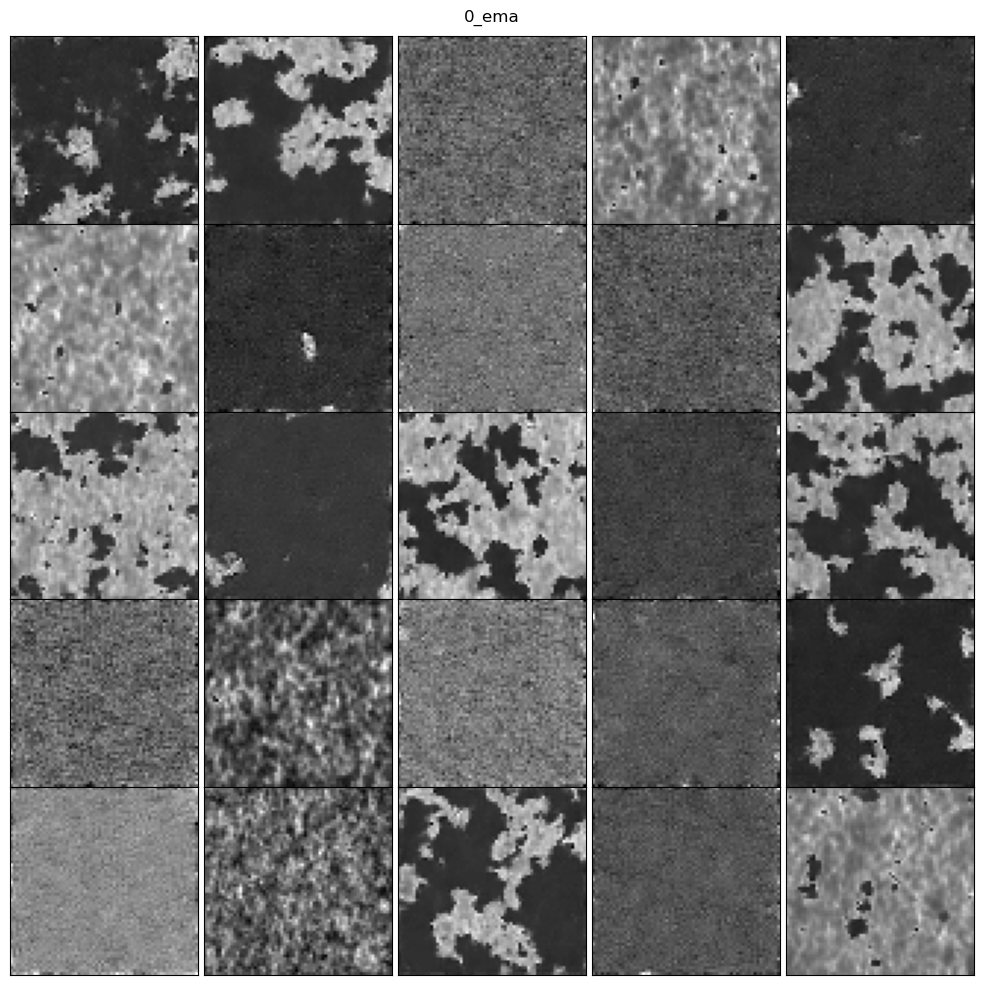

plotting (25, 1, 64, 64) 0


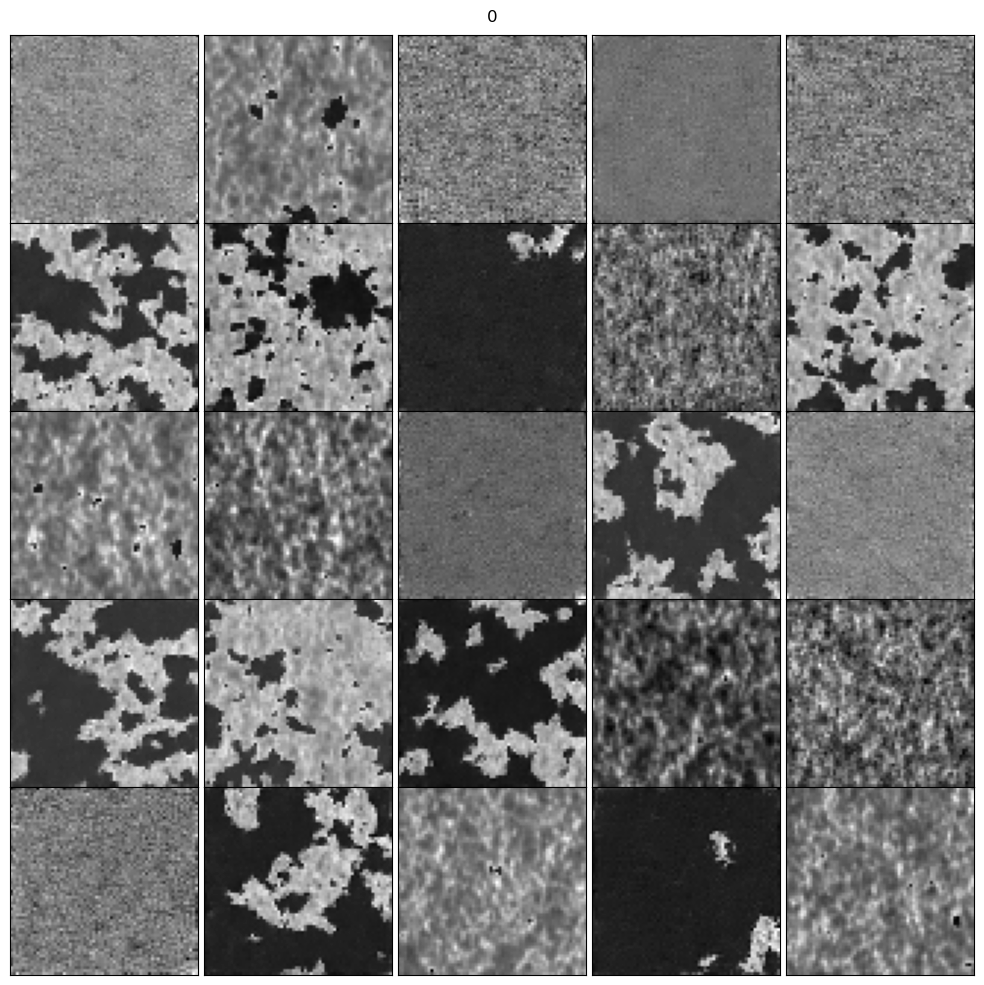

In [72]:
plot("outputs/0517-2237_guide_w0_ema.npy")
plot("outputs/0517-2237_guide_w0.npy")

(25, 1, 64, 64)


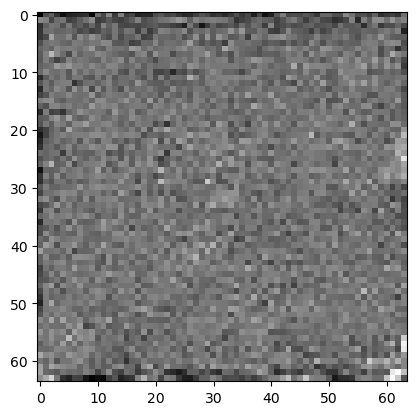

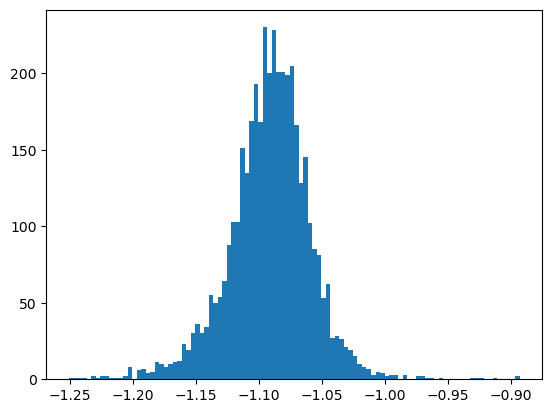

In [52]:
data = np.load("outputs/0517-1840_guide_w0.npy")
print(data.shape)
data = data[11,0]# * 2 - 1
plt.imshow(data, cmap='gray')#, vmin=-1, vmax=1)
plt.show()
_ = plt.hist(data.flatten(), bins=100)

In [53]:
data = np.load("outputs/0515-2215_guide_w-1_ema.npy")
print(data.shape)
data = data[8,0]
# data = np.maximum(data, 0)
plt.imshow(data, cmap='gray', vmin=-1, vmax=1)
plt.show()
_ = plt.hist(data.flatten(), bins=100)

FileNotFoundError: [Errno 2] No such file or directory: 'outputs/0515-2215_guide_w-1_ema.npy'

In [ ]:
for file in os.listdir('./outputs/'):
    if os.path.splitext(file)[-1] == '.npy':
        plot(os.path.join("./outputs", file))

plotting (25, 1, 64, 64) -1
plotting (25, 1, 64, 64) 0_ema
plotting (25, 1, 64, 64) 2_ema
plotting (25, 1, 64, 64) -2
plotting (25, 1, 64, 64) -0.5
plotting (25, 1, 64, 64) -2_ema
plotting (25, 1, 64, 64) 2
plotting (25, 1, 64, 64) -1_ema
plotting (25, 1, 64, 64) 0
plotting (25, 1, 64, 64) -0.5_ema


In [ ]:
ll

total 13056
drwxr-xr-x 4 bxia34    4096 May  6 23:33 data/
drwxr-xr-x 4 bxia34    4096 May 10 17:37 diffusion21cm/
-rwxr-xr-x 1 bxia34 3648914 May 15 02:19 diffusion.ipynb*
-rw-r--r-- 1 bxia34 4409529 Apr 11 01:23 generate_dataset.ipynb
-rw-r--r-- 1 bxia34   19223 Apr 27 00:42 generate_dataset.py
-rw-r--r-- 1 bxia34  576402 May 13 02:13 output.png
drwxr-xr-x 4 bxia34    4096 May 15 02:14 outputs/
-rw-r--r-- 1 bxia34     808 Apr 11 23:43 phoenix_generate_dataset.sbatch
-rw-r--r-- 1 bxia34       9 Feb  6 22:50 README.md
-rw-r--r-- 1 bxia34 1708306 May 14 23:50 real_random.png
-rw-r--r-- 1 bxia34   15888 Apr 12 01:10 Report-LargeScaleSuccess
-rw-r--r-- 1 bxia34 2946329 Mar 26 22:49 Report-SmallScaleSuccess
drwxr-xr-x 8 bxia34    4096 May 15 02:05 runs/


In [54]:
cd outputs/entire

[Errno 2] No such file or directory: 'outputs/entire'
/storage/coda1/p-jw254/0/bxia34/ml21cm


In [55]:
ll

total 11876
drwxr-xr-x 4 bxia34    4096 May  6 23:33 data/
drwxr-xr-x 2 bxia34    4096 May 17 19:57 ddpm21cm/
drwxr-xr-x 4 bxia34    4096 May 10 17:37 diffusion21cm/
-rwxr-xr-x 1 bxia34 2436958 May 17 19:57 diffusion.ipynb*
-rw-r--r-- 1 bxia34 4409529 Apr 11 01:23 generate_dataset.ipynb
-rw-r--r-- 1 bxia34   19223 Apr 27 00:42 generate_dataset.py
-rw-r--r-- 1 bxia34  576402 May 13 02:13 output.png
drwxr-xr-x 3 bxia34    4096 May 17 19:07 outputs/
-rw-r--r-- 1 bxia34     808 Apr 11 23:43 phoenix_generate_dataset.sbatch
-rw-r--r-- 1 bxia34       9 Feb  6 22:50 README.md
-rw-r--r-- 1 bxia34 1708306 May 14 23:50 real_random.png
-rw-r--r-- 1 bxia34   15888 Apr 12 01:10 Report-LargeScaleSuccess
-rw-r--r-- 1 bxia34 2946329 Mar 26 22:49 Report-SmallScaleSuccess
drwxr-xr-x 4 bxia34    4096 May 17 18:56 runs/


In [56]:
def plot(data, idx, row=5, col=5):
    # samples = np.load(filename)
    # params = filename.split('guide_w')[-1][:-4]
    # print("plotting", data.shape, params)
    plt.figure(figsize = (10,10))
    for i in range(config.n_sample):
        plt.subplot(row,col,i+1)
        plt.imshow(data[i,0,:,:])
        plt.xticks([])
        plt.yticks([])
        # plt.show()
    # plt.suptitle(params)
    plt.tight_layout()
    plt.subplots_adjust(wspace=0, hspace=0)
    # plt.show()
    plt.savefig(f'cond_gif{idx:03d}.png')
    plt.close()
    # plt.imshow(images[0,0])
    # plt.show()

In [57]:
data = np.load("0514-1801_guide_w0_ema_entire.npy")
print(data.shape)
print(data[0,:,0,...].shape)
for i in range(data.shape[0]):
    plot(data[i], i)

FileNotFoundError: [Errno 2] No such file or directory: '0514-1801_guide_w0_ema_entire.npy'

In [ ]:
from huggingface_hub import notebook_login
notebook_login()
from accelerate import notebook_launcher
import torch
from dataclasses import dataclass
import datasets
from datasets import load_dataset
from torchvision import transforms
from PIL import Image
from diffusers import DDPMScheduler
import torch.nn.functional as F
from accelerate import Accelerator, notebook_launcher
from diffusers.optimization import get_cosine_schedule_with_warmup
from diffusers import DDPMPipeline
from diffusers.utils import make_image_grid
import os
from huggingface_hub import create_repo, upload_folder
from tqdm.auto import tqdm
from pathlib import Path
import os
from time import sleep
import matplotlib.pyplot as plt
from diffusers import UNet2DModel

@dataclass
class TrainingConfig:
    image_size = 128
    train_batch_size = 16
    eval_batch_size = 16
    num_epochs = 50
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmup_steps = 500
    save_image_epochs = 10
    save_model_epochs = 30
    mixed_precision = 'fp16'
    output_dir = "ddpm-butterflies-128"

    push_to_hub = True
    hub_model_id = "Xsmos/ml21cm"
    hub_private_repo = False
    overwrite_output_dir = True
    seed = 0

config = TrainingConfig()


config.dataset_name = "huggan/smithsonian_butterflies_subset"
dataset = load_dataset(config.dataset_name, split='train')

preprocess = transforms.Compose(
    [
        transforms.Resize((config.image_size, config.image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5],[0.5]),
    ]
)

def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}

dataset.set_transform(transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=config.train_batch_size, shuffle=True)

model = UNet2DModel(
    sample_size = config.image_size,
    in_channels = 3,
    out_channels = 3,
    layers_per_block = 2,
    block_out_channels=(128,128,256,256,512,512),
    down_block_types=(
        'DownBlock2D',
        'DownBlock2D',
        'DownBlock2D',
        'DownBlock2D',
        'AttnDownBlock2D',
        'DownBlock2D',
    ),
    up_block_types=(
        'UpBlock2D',
        'AttnUpBlock2D',
        'UpBlock2D',
        'UpBlock2D',
        'UpBlock2D',
        'UpBlock2D',
    ),
)

noise_scheduler = DDPMScheduler(num_timesteps=1000)

optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer = optimizer,
    num_warmup_steps = config.lr_warmup_steps,
    num_training_steps = len(dataloader) * config.num_epochs,
)


def evaluate(config, epoch, pipeline):
    images = pipeline(
        batch_size = config.eval_batch_size,
        generator = torch.manual_seed(config.seed),
    ).images

    image_grid = make_image_grid(images, rows=4, cols=4)

    test_dir = os.path.join(config.output_dir, 'samples')
    os.makedirs(test_dir, exist_ok=True)
    image_grid.save(f'{test_dir}/{epoch:04d}.png')


def train_loop(config, model, noise_scheduler, optimizer, dataloader, lr_scheduler):
    import torch
    import numpy as np
    accelerator = Accelerator(
        mixed_precision = config.mixed_precision,
        gradient_accumulation_steps = config.gradient_accumulation_steps,
        log_with = 'tensorboard',
        project_dir = os.path.join(config.output_dir, 'logs'),
    )
    if accelerator.is_main_process:
        if config.output_dir is not None:
            os.makedirs(config.output_dir, exist_ok=True)
        if config.push_to_hub:
            repo_id = create_repo(
                repo_id = config.hub_model_id or Path(config.output_dir).name,
                exist_ok = True,
            ).repo_id
        accelerator.init_trackers('training_example')
    
    model, optimizer, dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, dataloader, lr_scheduler,
    )

    global_step = 0

    for epoch in range(config.num_epochs):
        progress_bar = tqdm(total=len(dataloader), disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")

        for step, batch in enumerate(dataloader):
            clean_images = batch['images']
            # print(clean_images.device)
            # sleep(1)
            noise = torch.randn(clean_images.shape, device=clean_images.device)
            bs = clean_images.shape[0]

            timesteps = torch.randint(
                0, noise_scheduler.config.num_timesteps, (bs,), device=clean_images.device, dtype=torch.int64
            )

            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

            with accelerator.accumulate(model):
                noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
                loss = F.mse_loss(noise_pred, noise)
                # print("loss:", loss)
                accelerator.backward(loss)

                accelerator.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

            progress_bar.update(1)
            logs = {
                'loss': loss.detach().item(),
                'lr': lr_scheduler.get_last_lr()[0],
                'step': global_step,
            }
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)
            global_step += 1

        if accelerator.is_main_process:
            pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)
            if (epoch + 1) % config.save_image_epochs == 0 or epoch == config.num_epochs - 1:
                evaluate(config, epoch, pipeline)
            if (epoch + 1) % config.save_model_epochs == 0 or epoch == config.num_epochs - 1:
                if config.push_to_hub:
                    upload_folder(
                        repo_id = repo_id,
                        folder_path = config.output_dir,
                        commit_message = f'Epoch {epoch}',
                        ignore_patterns=['step_*', 'epoch_*'],                        
                    )
                else:
                    pipeline.save_pretrained(config.output_dir)

# args = (config, model, noise_scheduler, optimizer, dataloader, lr_scheduler)

device_count = torch.cuda.device_count()
notebook_launcher(train_loop, (config, model, noise_scheduler, optimizer, dataloader, lr_scheduler), num_processes=1)

# test on 21cm dataset

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
import numpy as np
from accelerate import notebook_launcher
import torch
from dataclasses import dataclass
import datasets
from datasets import load_dataset
from torchvision import transforms
from PIL import Image
from diffusers import DDPMScheduler
import torch.nn.functional as F
from accelerate import Accelerator, notebook_launcher
from diffusers.optimization import get_cosine_schedule_with_warmup
from diffusers import DDPMPipeline
from diffusers.utils import make_image_grid
import os
from huggingface_hub import create_repo, upload_folder
from tqdm.auto import tqdm
from pathlib import Path
import os
from time import sleep
import matplotlib.pyplot as plt
from diffusers import UNet2DModel
import h5py
from datasets import Dataset

@dataclass
class TrainingConfig:
    num_images = 600
    image_size = [64,512]
    train_batch_size = 10
    eval_batch_size = 24
    num_epochs = 20
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmup_steps = 500
    save_image_epochs = 10
    save_model_epochs = 20
    mixed_precision = 'fp16'
    output_dir = "diffusion21cm"

    push_to_hub = True
    hub_model_id = "Xsmos/ml21cm"
    hub_private_repo = False
    overwrite_output_dir = True
    seed = 0

config = TrainingConfig()
# config.dataset_name = "diffusion21cm"
# dataset = load_dataset(config.dataset_name, split='train')

In [ ]:
ls $SCRATCH/

datasets/             LEN512-DIM256.h5    token
LEN128-DIM64-CUB8.h5  max_redshift.ipynb  version_diffusers_cache.txt


In [ ]:
with h5py.File("/storage/home/hcoda1/3/bxia34/scratch/LEN128-DIM64-CUB8.h5", 'r') as f:
    print(f.keys())
    print(f['brightness_temp'])
    Tb = f['brightness_temp'][:config.num_images,0,:config.image_size[0],:config.image_size[1]]
# Tb = Tb[:,None]
print(Tb.shape)

<KeysViewHDF5 ['brightness_temp', 'density', 'kwargs', 'params', 'redshifts_distances', 'seeds', 'xH_box']>
<HDF5 dataset "brightness_temp": shape (51200, 64, 64, 514), type "<f4">
(600, 64, 512)


(600, 64, 512)
<class 'numpy.ndarray'>


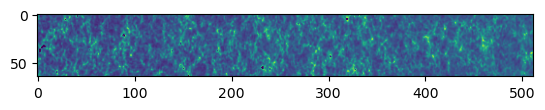

In [ ]:
print(Tb.shape)
print(type(Tb))
# plt.imshow(Tb[0])
plt.imshow(Tb[0])

In [ ]:
# config.dataset_name = "huggan/smithsonian_butterflies_subset"
# dataset = load_dataset(config.dataset_name, split='train')
# print(dataset.shape)
# print(type(dataset))
# print(dataset)
# print(dataset[0]['image'].convert('RGB'))
# print(np.shape(dataset[0]['image']))
# dataset[0]['image'].convert('RGB')

In [ ]:
def load_numpy_dataset(np_array, split='train'):
    assert split in ['train', 'test', 'validation'], "Invalid split name. Use 'train', 'test', or 'validation'."
    dataset = Dataset.from_dict({'image': np_array})
    return dataset
dataset = load_numpy_dataset(Tb)
print(type(dataset))
print(len(dataset))
print(np.shape(dataset))
print(dataset)
print(np.shape(dataset[0]['image']))

<class 'datasets.arrow_dataset.Dataset'>
600
(600, 1)
Dataset({
    features: ['image'],
    num_rows: 600
})
(64, 512)


In [ ]:
# test = np.array(dataset[0]['image'])
# print(test.shape)
# print(test.min(), test.max())
# test = (test-test.min())/(test.max()-test.min())
# # plt.imshow((test*255).astype(np.int))
# plt.imshow(test)
# plt.show()

In [ ]:
def normalize(image):
    initial_data = np.array(image)
    data = (initial_data - initial_data.min()) / (initial_data.max()-initial_data.min())
    # data = (normalized_data*255).astype(np.uint8)
    data = Image.fromarray(np.uint8(data*255))
    return data

preprocess = transforms.Compose(
    [
        # normalize(),
        transforms.Resize((config.image_size[0], config.image_size[1])),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5],[0.5]),
    ]
)

def transform(examples):
    images = [preprocess(normalize(image)) for image in examples['image']]
    # images = [preprocess(image) for image in examples['image']]
    # print(np.shape(images[0]))
    return {"images": images}

# datasets = transform(Tb)
dataset.set_transform(transform)

In [ ]:
dataset[0]['images'].shape

torch.Size([1, 64, 512])

In [ ]:
dataset[3]['images'].shape

torch.Size([1, 64, 512])

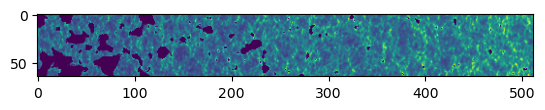

In [ ]:
plt.imshow(dataset[4]['images'][0])

In [ ]:
# dataset.set_transform(transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=config.train_batch_size, shuffle=True)

In [ ]:
next(iter(dataloader))['images'].shape

torch.Size([10, 1, 64, 512])

In [ ]:
model = UNet2DModel(
    sample_size = config.image_size,
    in_channels = 1,
    out_channels = 1,
    layers_per_block = 2,
    block_out_channels=(128,128,256,256,512,512),
    down_block_types=(
        'DownBlock2D',
        'DownBlock2D',
        'DownBlock2D',
        'DownBlock2D',
        'AttnDownBlock2D',
        'DownBlock2D',
    ),
    up_block_types=(
        'UpBlock2D',
        'AttnUpBlock2D',
        'UpBlock2D',
        'UpBlock2D',
        'UpBlock2D',
        'UpBlock2D',
    ),
)

noise_scheduler = DDPMScheduler(num_timesteps=1000)

optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer = optimizer,
    num_warmup_steps = config.lr_warmup_steps,
    num_training_steps = len(dataloader) * config.num_epochs,
)


def evaluate(config, epoch, pipeline):
    images = pipeline(
        batch_size = config.eval_batch_size,
        generator = torch.manual_seed(config.seed),
    ).images

    image_grid = make_image_grid(images, rows=12, cols=2)

    test_dir = os.path.join(config.output_dir, 'samples')
    os.makedirs(test_dir, exist_ok=True)
    image_grid.save(f'{test_dir}/{epoch:04d}.png')


def train_loop(config, model, noise_scheduler, optimizer, dataloader, lr_scheduler):
    import torch
    import numpy as np
    accelerator = Accelerator(
        mixed_precision = config.mixed_precision,
        gradient_accumulation_steps = config.gradient_accumulation_steps,
        log_with = 'tensorboard',
        project_dir = os.path.join(config.output_dir, 'logs'),
    )
    if accelerator.is_main_process:
        if config.output_dir is not None:
            os.makedirs(config.output_dir, exist_ok=True)
        if config.push_to_hub:
            repo_id = create_repo(
                repo_id = config.hub_model_id or Path(config.output_dir).name,
                exist_ok = True,
            ).repo_id
        accelerator.init_trackers('training_example')
    
    model, optimizer, dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, dataloader, lr_scheduler,
    )

    global_step = 0
    for epoch in range(config.num_epochs):
        progress_bar = tqdm(total=len(dataloader), disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")
    
        
        for step, batch in enumerate(dataloader):
            clean_images = batch['images']
            # print(clean_images.device)
            # sleep(1)
            noise = torch.randn(clean_images.shape, device=clean_images.device)
            bs = clean_images.shape[0]

            timesteps = torch.randint(
                0, noise_scheduler.config.num_timesteps, (bs,), device=clean_images.device, dtype=torch.int64
            )

            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

            with accelerator.accumulate(model):
                noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
                loss = F.mse_loss(noise_pred, noise)
                # print("loss:", loss)
                accelerator.backward(loss)

                accelerator.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

            progress_bar.update(1)
            logs = {
                'loss': loss.detach().item(),
                'lr': lr_scheduler.get_last_lr()[0],
                'step': global_step,
            }
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)
            global_step += 1

        if accelerator.is_main_process:
            pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)
            if (epoch + 1) % config.save_image_epochs == 0 or epoch == config.num_epochs - 1:
                evaluate(config, epoch, pipeline)
            if (epoch + 1) % config.save_model_epochs == 0 or epoch == config.num_epochs - 1:
                if config.push_to_hub:
                    upload_folder(
                        repo_id = repo_id,
                        folder_path = config.output_dir,
                        commit_message = f'Epoch {epoch}',
                        ignore_patterns=['step_*', 'epoch_*'],                        
                    )
                else:
                    pipeline.save_pretrained(config.output_dir)


In [ ]:
# args = (config, model, noise_scheduler, optimizer, dataloader, lr_scheduler)
device_count = torch.cuda.device_count()
notebook_launcher(train_loop, (config, model, noise_scheduler, optimizer, dataloader, lr_scheduler), num_processes=1)

Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Launching training on one GPU.


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0009.png:   0%|          | 0.00/1.15M [00:00<?, ?B/s]

Upload 3 LFS files:   0%|          | 0/3 [00:00<?, ?it/s]

events.out.tfevents.1715452041.atl1-1-03-003-19-0.pace.gatech.edu.11077.0:   0%|          | 0.00/152k [00:00<?…

0019.png:   0%|          | 0.00/1.15M [00:00<?, ?B/s]

loss = 0.0133